In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from PIL import Image
from numpy import asarray

from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import datasets,layers, models

# CONNECT DENGAN DIRECTORY

In [2]:
base_dir = "blobs.rect"
latih =  "latih"
validasi = "validasi"
!ls "D:\TUGAS\Kuliah\Semester8\SourcesCode\SimulasiCNN\blobs.rect"

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
bahan_dir = os.path.join(base_dir)
train_dir = os.path.join(latih)
valid_dir = os.path.join(validasi)

In [4]:
gradeA_dir = os.path.join(bahan_dir, 'gradeA/')
gradeB_dir = os.path.join(bahan_dir, 'gradeB/')
gradeC_dir = os.path.join(bahan_dir, 'gradeC/')

print("Jumlah data tiap kelas")
print("Jumlah gambar grade  A : ", len(os.listdir(gradeA_dir)))
print("Jumlah gambar grade  B : ", len(os.listdir(gradeB_dir)))
print("Jumlah gambar grade  C : ", len(os.listdir(gradeC_dir)))
print("Total dataset : ", len(os.listdir(gradeA_dir)) + len(os.listdir(gradeB_dir)) + len(os.listdir(gradeC_dir)))

Jumlah data tiap kelas
Jumlah gambar grade  A :  738
Jumlah gambar grade  B :  648
Jumlah gambar grade  C :  731
Total dataset :  2117


In [5]:
# direktori isi latih/training
train_gradeA = os.path.join(train_dir, 'gradeA/')
train_gradeB = os.path.join(train_dir, 'gradeB/')
train_gradeC = os.path.join(train_dir, 'gradeC/')

# direktori isi validasi
valid_gradeA = os.path.join(valid_dir, 'gradeA/')
valid_gradeB = os.path.join(valid_dir, 'gradeB/')
valid_gradeC = os.path.join(valid_dir, 'gradeC/')

# MEMBAGI DATASET MENJADI DATA TRAINING DAN DATA VALIDATION

In [18]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size - train_size

  randomized  = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files   = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

# jumlah pembagian data training dan testing
train_ratio = 0.9

#pembagian training dan validasi 
#gradeA
source_00 = gradeA_dir
train_00  = train_gradeA
val_00    = valid_gradeA
train_val_split(source_00, train_00, val_00, train_ratio)

#gradeB
source_01 = gradeB_dir
train_01  = train_gradeB
val_01    = valid_gradeB
train_val_split(source_01, train_01, val_01, train_ratio)

#gradeC
source_02 = gradeC_dir
train_02  = train_gradeC
val_02    = valid_gradeC
train_val_split(source_02, train_02, val_02, train_ratio)

In [7]:
print("Jumlah all grade A   : ", len(os.listdir(gradeA_dir)))
print("Jumlah train grade A : ", len(os.listdir(train_gradeA)))
print("Jumlah val grade A   : ", len(os.listdir(valid_gradeA)))

print("\nJumlah all grade B   : ", len(os.listdir(gradeB_dir)))
print("Jumlah train grade B : ", len(os.listdir(train_gradeB)))
print("Jumlah val grade B   : ", len(os.listdir(valid_gradeB)))

print("\nJumlah all grade C   : ", len(os.listdir(gradeC_dir)))
print("Jumlah train grade C : ", len(os.listdir(train_gradeC)))
print("Jumlah val grade C   : ", len(os.listdir(valid_gradeC)))

Jumlah all grade A   :  738
Jumlah train grade A :  731
Jumlah val grade A   :  141

Jumlah all grade B   :  648
Jumlah train grade B :  641
Jumlah val grade B   :  123

Jumlah all grade C   :  731
Jumlah train grade C :  723
Jumlah val grade C   :  140


# MOBILENET V2

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen       = ImageDataGenerator(
    rescale         = 1./255,
    rotation_range  = 30,
    horizontal_flip = True,
    shear_range     = 0.3,
    fill_mode       = 'nearest',
)

val_datagen = ImageDataGenerator(
    rescale         = 1./255,
    rotation_range  = 30,
    horizontal_flip = True,
    shear_range     = 0.3,
    fill_mode       = 'nearest',
)

In [7]:
IMG_SIZE = (128,128)
BATCH_SIZE = 32

# train_dir = os.path.join(base_dir, 'latih')
# validation_dir = os.path.join(base_dir, 'validasi')

# train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, class_mode= 'categorical')
# validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, class_mode= 'categorical')

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode = 'rgb'
)
valid_dataset = val_datagen.flow_from_directory(
    valid_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle    = False,
    class_mode = 'categorical',
    color_mode = 'rgb'
)

Found 1904 images belonging to 3 classes.
Found 213 images belonging to 3 classes.


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

for layer in MobileNetV2.layers:
    MobileNetV2.trainable = False

# UJI COBA CUSTOM MODEL KE-1

In [9]:
x = MobileNetV2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)
modelku = tf.keras.Model(inputs=MobileNetV2.input, outputs = output)

In [10]:
modelku.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [11]:
base_learning_rate = 0.0001
modelku.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

In [12]:
history = modelku.fit(train_dataset, epochs=10, validation_data=valid_dataset)

Epoch 1/10
60/60 [==============================] - 23s 332ms/step - loss: 1.1367 - accuracy: 0.4165 - val_loss: 0.9645 - val_accuracy: 0.5305
Epoch 2/10
60/60 [==============================] - 20s 327ms/step - loss: 0.8036 - accuracy: 0.6870 - val_loss: 0.7314 - val_accuracy: 0.6948
Epoch 3/10
60/60 [==============================] - 20s 330ms/step - loss: 0.6086 - accuracy: 0.8146 - val_loss: 0.5562 - val_accuracy: 0.8498
Epoch 4/10
60/60 [==============================] - 21s 344ms/step - loss: 0.5128 - accuracy: 0.8550 - val_loss: 0.4649 - val_accuracy: 0.8920
Epoch 5/10
60/60 [==============================] - 21s 342ms/step - loss: 0.4218 - accuracy: 0.8892 - val_loss: 0.4031 - val_accuracy: 0.8920
Epoch 6/10
60/60 [==============================] - 20s 337ms/step - loss: 0.3760 - accuracy: 0.9007 - val_loss: 0.3966 - val_accuracy: 0.8873
Epoch 7/10
60/60 [==============================] - 21s 341ms/step - loss: 0.3361 - accuracy: 0.9076 - val_loss: 0.3009 - val_accuracy: 0.9202

In [21]:
modelku.save('modelku-no_dropout.h5')

# Training dan validation accurasi dan loss

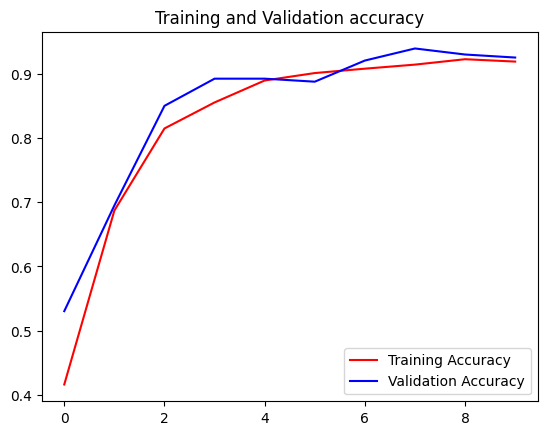

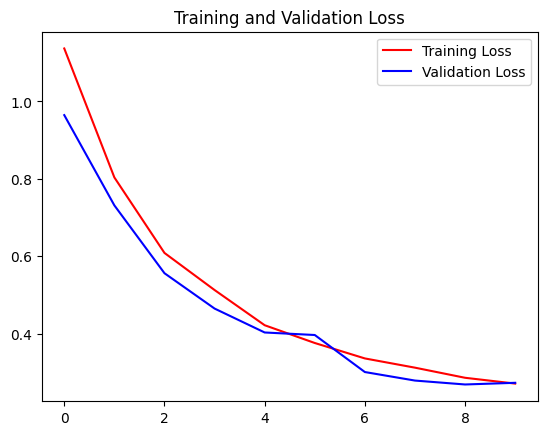

In [13]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.show()

# Menampilkan precission, recall, dan f1-score

In [14]:
import numpy as np
from sklearn.metrics import classification_report

# Evaluasi model
y_true = valid_dataset.classes
Y_pred = modelku.predict(valid_dataset, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# Tampilkan laporan klasifikasi
target_names = list(valid_dataset.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

7/7 [==============================] - 3s 293ms/step
              precision    recall  f1-score   support

      GradeA       0.88      0.92      0.90        74
      GradeB       0.90      0.88      0.89        65
      GradeC       1.00      0.99      0.99        74

    accuracy                           0.93       213
   macro avg       0.93      0.93      0.93       213
weighted avg       0.93      0.93      0.93       213



# CONFUSION MATRIX

7/7 [==============================] - 2s 300ms/step


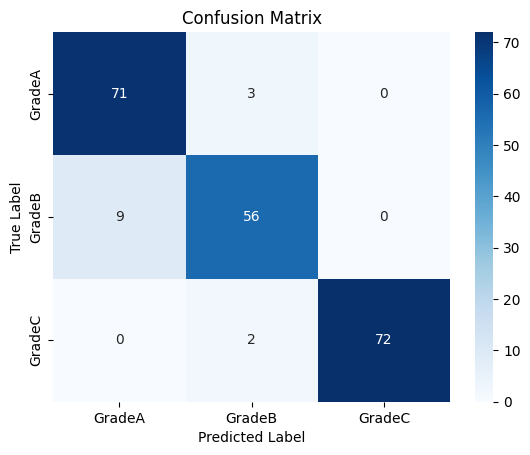

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_list = os.listdir(train_dir)

# membuat prediksi pada data validasi
y_pred = modelku.predict(valid_dataset)
y_pred = np.argmax(y_pred, axis=1)

# mengambil label yang sebenarnya
y_true = valid_dataset.classes

# membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# menampilkan confusion matrix dengan heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_list, yticklabels=class_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Export TFLITE

In [22]:
TFLITE_MODEL = "tflite/export-2-no_dropout.tflite"
TFLITE_QUANT_MODEL = "tflite/export-2-no_dropout-quant.tflite"

In [23]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : modelku(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(modelku.inputs[0].shape, modelku.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:


'ls' is not recognized as an internal or external command,
operable program or batch file.
